In [ ]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d jangedoo/utkface-new
# !unzip utkface-new.zip -d utkface

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os


In [8]:
folder_path = '/Users/owner/Desktop/deep-learning/multipleoutputproject/utkface/utkface_aligned_cropped/UTKFace'
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [9]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})
df.head(5)



,age,gender,img
0,9,1,9_1_2_20161219204347420.jpg.chip.jpg
1,36,0,36_0_1_20170117163203851.jpg.chip.jpg
2,86,1,86_1_0_20170120225751953.jpg.chip.jpg
3,26,1,26_1_0_20170116171048641.jpg.chip.jpg
4,1,1,1_1_2_20161219154612988.jpg.chip.jpg


In [ ]:
import os

# Example:  folder path
folder_path = '/Users/owner/Desktop/deep-learning/multipleoutputproject/utkface/UTKFace/'

df['image_path'] = df['img'].apply(lambda x: os.path.join(folder_path, x))


print(df[['img', 'image_path']].head())

                                     img  \
0   9_1_2_20161219204347420.jpg.chip.jpg   
1  36_0_1_20170117163203851.jpg.chip.jpg   
2  86_1_0_20170120225751953.jpg.chip.jpg   
3  26_1_0_20170116171048641.jpg.chip.jpg   
4   1_1_2_20161219154612988.jpg.chip.jpg   

                                          image_path  
0  /Users/owner/Desktop/deep-learning/multipleout...  
1  /Users/owner/Desktop/deep-learning/multipleout...  
2  /Users/owner/Desktop/deep-learning/multipleout...  
3  /Users/owner/Desktop/deep-learning/multipleout...  
4  /Users/owner/Desktop/deep-learning/multipleout...  


In [11]:
df.head(5)

,age,gender,img,image_path
0,9,1,9_1_2_20161219204347420.jpg.chip.jpg,/Users/owner/Desktop/deep-learning/multipleout...
1,36,0,36_0_1_20170117163203851.jpg.chip.jpg,/Users/owner/Desktop/deep-learning/multipleout...
2,86,1,86_1_0_20170120225751953.jpg.chip.jpg,/Users/owner/Desktop/deep-learning/multipleout...
3,26,1,26_1_0_20170116171048641.jpg.chip.jpg,/Users/owner/Desktop/deep-learning/multipleout...
4,1,1,1_1_2_20161219154612988.jpg.chip.jpg,/Users/owner/Desktop/deep-learning/multipleout...


In [12]:
df['image_path'][1]


'/Users/owner/Desktop/deep-learning/multipleoutputproject/utkface/UTKFace/36_0_1_20170117163203851.jpg.chip.jpg'

In [13]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import cv2
import os

In [15]:
IMG_SIZE = (128, 128)

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # normalize to 0–1
    return img

# Convert your df['image_path'] into NumPy arrays
X = np.array([load_image(p) for p in df['image_path']])

# Targets
y_age = df['age'].values
y_gender = df['gender'].values

In [16]:
age_min = y_age.min()
age_max = y_age.max()

y_age_norm = (y_age - age_min) / (age_max - age_min)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_age_train, y_age_val, y_gender_train, y_gender_val = train_test_split(
    X, y_age_norm, y_gender, test_size=0.2, random_state=42
)

In [21]:
input_layer = layers.Input(shape=(128, 128, 3))

# Shared feature extractor
x = layers.Conv2D(32, (3,3), activation='relu')(input_layer)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output 1: Age (regression)
age_output = layers.Dense(1,name='age_output')(x)

# Output 2: Gender (classification)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

model = models.Model(inputs=input_layer, outputs=[age_output, gender_output])

In [22]:
model.compile(
    optimizer='adam',
    loss={
        'age_output': 'mae',               # regression → mean absolute error
        'gender_output': 'binary_crossentropy'  # classification → BCE
    },
    metrics={
        'age_output': ['mae'],
        'gender_output': ['accuracy']
    }
)

In [23]:
history = model.fit(
    X_train,
    {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_data=(X_val, {'age_output': y_age_val, 'gender_output': y_gender_val}),
    epochs=10,
    batch_size=32
)

Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - age_output_loss: 0.6538 - age_output_mae: 0.6538 - gender_output_accuracy: 0.6745 - gender_output_loss: 0.6174 - loss: 1.2713 - val_age_output_loss: 0.1999 - val_age_output_mae: 0.1997 - val_gender_output_accuracy: 0.8355 - val_gender_output_loss: 0.3844 - val_loss: 0.5836
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - age_output_loss: 0.2618 - age_output_mae: 0.2618 - gender_output_accuracy: 0.8135 - gender_output_loss: 0.4550 - loss: 0.7166 - val_age_output_loss: 0.2003 - val_age_output_mae: 0.2000 - val_gender_output_accuracy: 0.8636 - val_gender_output_loss: 0.3358 - val_loss: 0.5338
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - age_output_loss: 0.1533 - age_output_mae: 0.1533 - gender_output_accuracy: 0.8304 - gender_output_loss: 0.4129 - loss: 0.5660 - val_age_output_loss: 0.1322 - val_age_output_mae: 0.1321 - val_gender_output_accuracy: 0.8701 - val_gender_output_loss: 0.3486 - val_loss: 0.4765
Epoch 4/10

In [24]:
model.save("final_age_gender_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


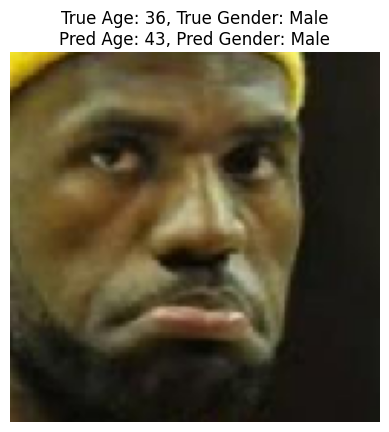

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# --- Path to your image
img_path = '/Users/owner/Desktop/deep-learning/multipleoutputproject/utkface/UTKFace/36_0_1_20170117163203851.jpg.chip.jpg'

# --- Extract actual age and gender from filename
filename = os.path.basename(img_path)
true_age = int(filename.split('_')[0])
true_gender_class = int(filename.split('_')[1])
gender_label = {0: "Male", 1: "Female"}
true_gender_label = gender_label[true_gender_class]

# --- Load saved model
model = tf.keras.models.load_model(
    '/Users/owner/Desktop/deep-learning/multipleoutputproject/final_age_gender_model.h5',
    compile=False
)

# --- Load and preprocess image
img = image.load_img(img_path, target_size=(128, 128))  # match your model input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # scale if model was trained this way

# --- Predict age and gender
pred_age, pred_gender = model.predict(img_array)

# --- Unscale age if normalized during training
pred_age_unscaled = pred_age[0][0] * (age_max - age_min) + age_min  # replace age_min/max

# --- Convert predicted gender
pred_gender_class = int(pred_gender[0][0] > 0.5)
pred_gender_label = gender_label[pred_gender_class]

# --- Show image with true and predicted values
plt.imshow(img)
plt.axis('off')
plt.title(
    f"True Age: {true_age}, True Gender: {true_gender_label}\n"
    f"Pred Age: {pred_age_unscaled:.0f}, Pred Gender: {pred_gender_label}",
    fontsize=12
)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


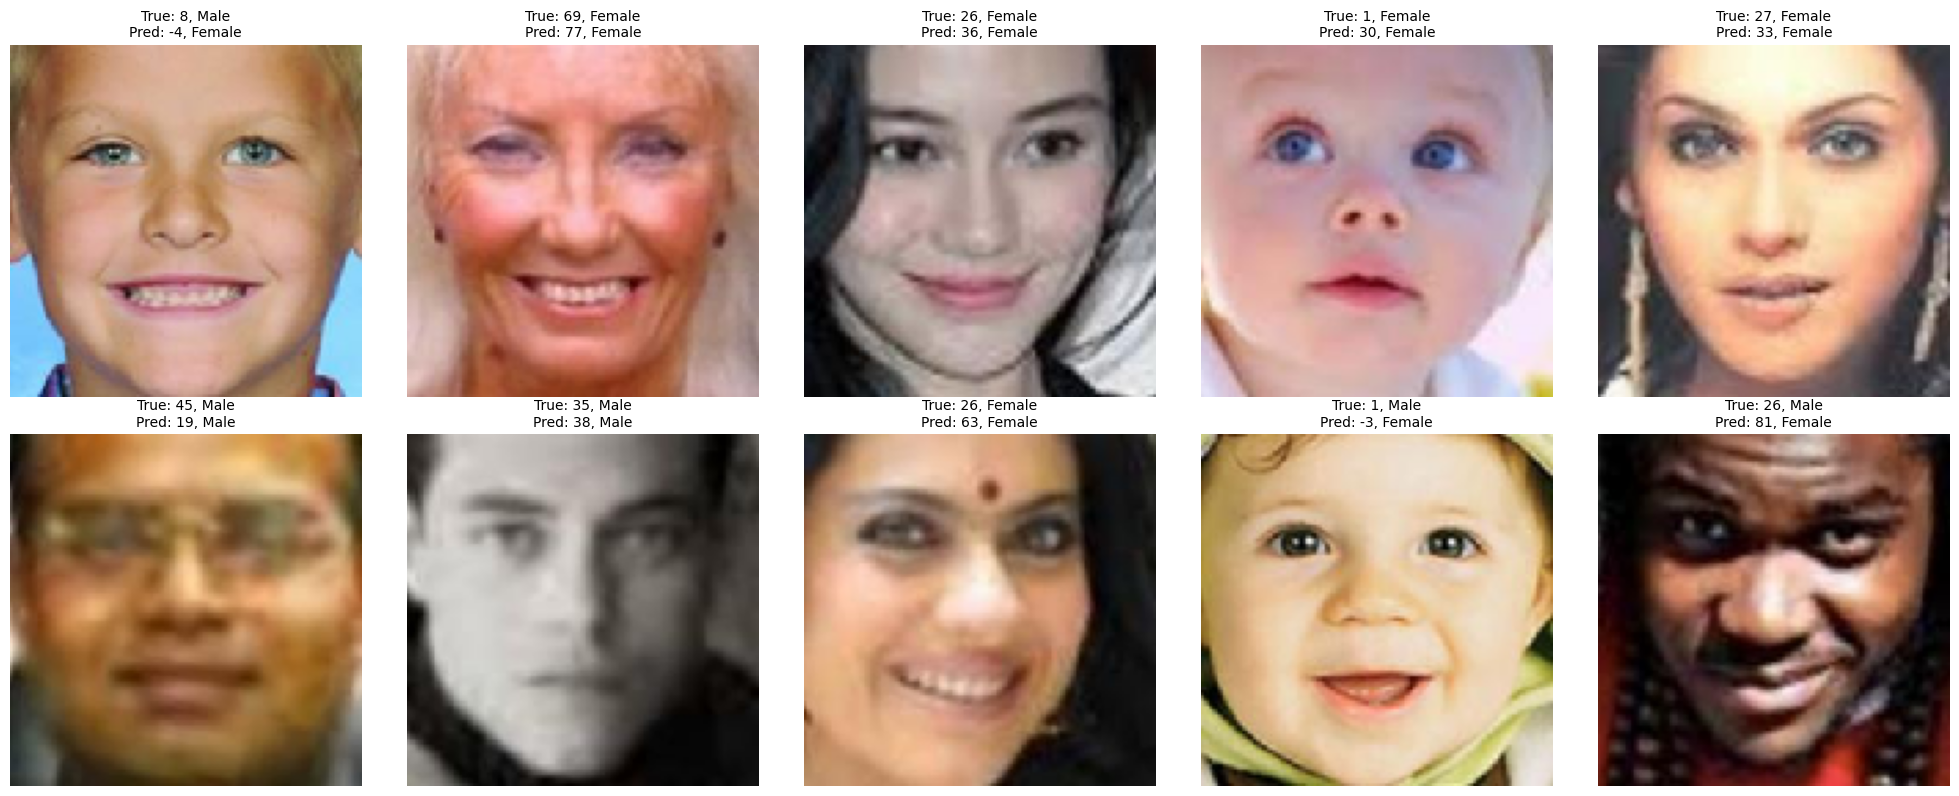

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import glob

# --- Folder containing UTKFace images
folder_path = '/Users/owner/Desktop/deep-learning/multipleoutputproject/utkface/UTKFace/'

# --- Get 10 random image paths
all_images = glob.glob(os.path.join(folder_path, '*.jpg'))
np.random.seed(42)
sample_images = np.random.choice(all_images, 10, replace=False)

# --- Load saved model
model = tf.keras.models.load_model(
    '/Users/owner/Desktop/deep-learning/multipleoutputproject/final_age_gender_model.h5',
    compile=False
)

# --- Parameters for age scaling (use same as during training)
age_min = 0   # replace with your training min age
age_max = 116 # replace with your training max age

# --- Gender label mapping
gender_label = {0: "Male", 1: "Female"}

# --- Plot setup
plt.figure(figsize=(20, 8))

for i, img_path in enumerate(sample_images):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    pred_age, pred_gender = model.predict(img_array)
    pred_age_unscaled = pred_age[0][0] * (age_max - age_min) + age_min
    pred_gender_class = int(pred_gender[0][0] > 0.5)
    pred_gender_label = gender_label[pred_gender_class]

    # Extract true age and gender from filename
    filename = os.path.basename(img_path)
    true_age = int(filename.split('_')[0])
    true_gender_class = int(filename.split('_')[1])
    true_gender_label = gender_label[true_gender_class]

    # Plot
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"True: {true_age}, {true_gender_label}\nPred: {pred_age_unscaled:.0f}, {pred_gender_label}",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# conclusion
our model is performing well: age predictions are accurate (low MAE) and gender classification is strong (~88% accuracy).